## Regression Using NLP Text

This model will appear as 'DunnBC22/distilbert-base-uncased-Regression-The_Simpsons' on my HuggingFace profile.

Data Source: https://www.kaggle.com/datasets/mattbarty/the-simpsons-s1s32-imdb-scores-episode-info

#### Import Necessary Libraries

In [63]:
import os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, set_seed, get_scheduler

from datasets import Dataset, DatasetDict

#### Ingest Data, Drop Unnecessary Columns, & Rename Remaining Columns

In [64]:
data = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/imdb_simpsons_dataset.csv', engine="c")
data.drop(columns=['episode_no_abs', 'episode_votes', 'episode_votes', 'season_no', 'episode_no', 'episode_airdate', 'episode_name'], inplace=True)

data.rename(columns={'episode_score' : 'label', 
                     'episode_description' : 'text'}, 
            inplace=True)

data

,label,text
0,8.2,Homer is forced to become a department store S...
1,7.7,Bart ends up at a school for gifted children a...
2,7.4,"After losing his job, Homer contemplates endin..."
3,7.7,After being embarrassed by the rest of the fam...
4,8.0,After being beaten up by Nelson Muntz one too ...
...,...,...
700,6.8,Mr. Burns joins the plant-based burger busines...
701,6.2,Lisa's imaginary friend is a depressed British...
702,7.2,Lisa makes a shocking college decision that hu...
703,6.5,A British secret agent comes to Springfield to...


#### Visualize Distribution of Scores

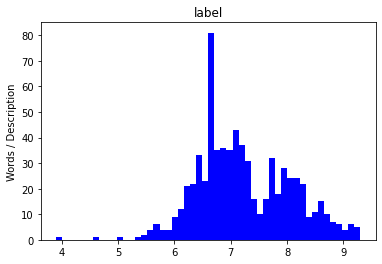

In [65]:
data.hist("label", color="Blue", grid=False, bins=50)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Words / Description')
plt.show()

#### Visualize Distribution of Message Length

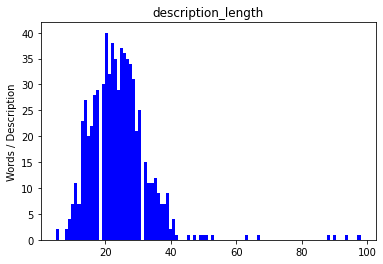

In [66]:
data['description_length'] = data['text'].str.split().apply(len)

data.hist("description_length", color="Blue", grid=False, bins=100)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Words / Description')
plt.show()

#### Remove Outliers Based on Above Visuals

In [67]:
data = data[data['label'] > 5.2]
data = data[data['description_length'] < 51]
data = data.drop(columns=['description_length'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 0 to 704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   694 non-null    float64
 1   text    694 non-null    object 
dtypes: float64(1), object(1)
memory usage: 16.3+ KB


#### Convert Pandas DataFrame to Datasets

In [68]:
dataset = Dataset.from_pandas(data)

#### Split into Train/Test/Validate Datasets & Combine into DatasetDict

In [69]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (555, 3)
Testing data shape: (70, 3)
Eval data shape: (69, 3)


#### Basic Values

In [70]:
num_of_epochs = 15
max_input_len = 68
model_ckpt = "distilbert-base-uncased"
device = "cpu"
num_labels = 1
BATCH_SIZE=64
model_name = f"{model_ckpt}-Regression-The_Simpsons"
learning_rate=2e-5
set_seed(42)

#### HuggingFace Access Token & Install git lfs 

In [71]:
# HuggingFace Access Token ... 

!git lfs install

Git LFS initialized.


#### Tokenize Whole Dataset

In [72]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_len, return_tensors="np")

encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /Users/briandunn/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.1",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /Users/briandunn/.cache/huggingface/transformers/0e1bbfd

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Print Example to Ensure Changes Worked as Expected

In [73]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'label': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 555
})


#### Initialize Model

In [74]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /Users/briandunn/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve

#### Metrics Evaluation Function

In [75]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    #r2 = r2_score(labels, logits)
    
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    accuracy = sum(
        [1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "accuracy": accuracy} #, "r2": r2

#### Trainer Arguments

In [76]:
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=num_of_epochs, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=learning_rate,
                                  evaluation_strategy='epoch',
                                  save_total_limit=12,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='rmse',
                                  greater_is_better=False,
                                  save_strategy='epoch', 
                                  optim='adamw_hf',
                                  push_to_hub=True)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


#### Instantiate Optimizer

In [77]:
optimizer_name = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_of_epochs * len(encoded_ds['train'])

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer_name, num_warmup_steps=0, num_training_steps=num_training_steps
)

optimizer = [optimizer_name, lr_scheduler]

#### Build Trainer

In [78]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  optimizers=optimizer, 
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics_for_regression)

/Users/briandunn/Documents/nlpnn/nlp_projects/distilbert-base-uncased-Regression-The_Simpsons is already a clone of https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-The_Simpsons. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train the Trainer

In [79]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 555
  Num Epochs = 15
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 135


  0%|          | 0/135 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-9
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-9/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-9/pytorch_model.bin


{'eval_loss': 37.491085052490234, 'eval_mse': 37.4910888671875, 'eval_rmse': 6.122996807098389, 'eval_mae': 6.0774126052856445, 'eval_accuracy': 0.0, 'eval_runtime': 7.4738, 'eval_samples_per_second': 9.232, 'eval_steps_per_second': 0.268, 'epoch': 1.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-36] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-18
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-18/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-18/pytorch_model.bin


{'eval_loss': 25.51958465576172, 'eval_mse': 25.51958656311035, 'eval_rmse': 5.05169153213501, 'eval_mae': 4.996051788330078, 'eval_accuracy': 0.0, 'eval_runtime': 7.4745, 'eval_samples_per_second': 9.231, 'eval_steps_per_second': 0.268, 'epoch': 2.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-45] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-27
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-27/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-27/pytorch_model.bin


{'eval_loss': 17.048091888427734, 'eval_mse': 17.04808807373047, 'eval_rmse': 4.128932952880859, 'eval_mae': 4.062273025512695, 'eval_accuracy': 0.0, 'eval_runtime': 7.4689, 'eval_samples_per_second': 9.238, 'eval_steps_per_second': 0.268, 'epoch': 3.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-54] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-36
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-36/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-36/pytorch_model.bin


{'eval_loss': 11.334267616271973, 'eval_mse': 11.334266662597656, 'eval_rmse': 3.366640329360962, 'eval_mae': 3.285665512084961, 'eval_accuracy': 0.0, 'eval_runtime': 7.4969, 'eval_samples_per_second': 9.204, 'eval_steps_per_second': 0.267, 'epoch': 4.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-63] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-45
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-45/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-45/pytorch_model.bin


{'eval_loss': 7.3299560546875, 'eval_mse': 7.329953670501709, 'eval_rmse': 2.7073886394500732, 'eval_mae': 2.606602191925049, 'eval_accuracy': 0.0, 'eval_runtime': 7.6041, 'eval_samples_per_second': 9.074, 'eval_steps_per_second': 0.263, 'epoch': 5.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-72] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-54
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-54/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-54/pytorch_model.bin


{'eval_loss': 4.561525344848633, 'eval_mse': 4.561525821685791, 'eval_rmse': 2.135772943496704, 'eval_mae': 2.0073254108428955, 'eval_accuracy': 0.014492753623188406, 'eval_runtime': 7.5432, 'eval_samples_per_second': 9.147, 'eval_steps_per_second': 0.265, 'epoch': 6.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-81] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-63
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-63/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-63/pytorch_model.bin


{'eval_loss': 2.598322629928589, 'eval_mse': 2.598323345184326, 'eval_rmse': 1.611931562423706, 'eval_mae': 1.446689248085022, 'eval_accuracy': 0.057971014492753624, 'eval_runtime': 7.4974, 'eval_samples_per_second': 9.203, 'eval_steps_per_second': 0.267, 'epoch': 7.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-90] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-72
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-72/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-72/pytorch_model.bin


{'eval_loss': 1.3512496948242188, 'eval_mse': 1.3512499332427979, 'eval_rmse': 1.1624327898025513, 'eval_mae': 0.9480680227279663, 'eval_accuracy': 0.2898550724637681, 'eval_runtime': 7.5667, 'eval_samples_per_second': 9.119, 'eval_steps_per_second': 0.264, 'epoch': 8.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-99] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-81
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-81/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-81/pytorch_model.bin


{'eval_loss': 0.6723872423171997, 'eval_mse': 0.6723872423171997, 'eval_rmse': 0.8199922442436218, 'eval_mae': 0.6135056018829346, 'eval_accuracy': 0.5797101449275363, 'eval_runtime': 7.4873, 'eval_samples_per_second': 9.216, 'eval_steps_per_second': 0.267, 'epoch': 9.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-108] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-90
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-90/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-90/pytorch_model.bin


{'eval_loss': 0.5318713784217834, 'eval_mse': 0.531871497631073, 'eval_rmse': 0.7292951941490173, 'eval_mae': 0.5782299041748047, 'eval_accuracy': 0.5217391304347826, 'eval_runtime': 7.5474, 'eval_samples_per_second': 9.142, 'eval_steps_per_second': 0.265, 'epoch': 10.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-117] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-99
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-99/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-99/pytorch_model.bin


{'eval_loss': 0.5245146155357361, 'eval_mse': 0.5245146155357361, 'eval_rmse': 0.7242338061332703, 'eval_mae': 0.5948888659477234, 'eval_accuracy': 0.4927536231884058, 'eval_runtime': 7.4964, 'eval_samples_per_second': 9.204, 'eval_steps_per_second': 0.267, 'epoch': 11.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-126] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-108
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-108/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-108/pytorch_model.bin


{'eval_loss': 0.5180248022079468, 'eval_mse': 0.5180248022079468, 'eval_rmse': 0.7197393774986267, 'eval_mae': 0.5578354001045227, 'eval_accuracy': 0.5217391304347826, 'eval_runtime': 7.5067, 'eval_samples_per_second': 9.192, 'eval_steps_per_second': 0.266, 'epoch': 12.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-135] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-117
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-117/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-117/pytorch_model.bin


{'eval_loss': 0.506447434425354, 'eval_mse': 0.5064475536346436, 'eval_rmse': 0.7116512656211853, 'eval_mae': 0.558660089969635, 'eval_accuracy': 0.5217391304347826, 'eval_runtime': 7.5183, 'eval_samples_per_second': 9.178, 'eval_steps_per_second': 0.266, 'epoch': 13.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-9] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-126
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-126/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-126/pytorch_model.bin


{'eval_loss': 0.56344074010849, 'eval_mse': 0.5634409189224243, 'eval_rmse': 0.7506270408630371, 'eval_mae': 0.5621675848960876, 'eval_accuracy': 0.5942028985507246, 'eval_runtime': 7.5531, 'eval_samples_per_second': 9.135, 'eval_steps_per_second': 0.265, 'epoch': 14.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-18] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 69
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons/checkpoint-135
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-135/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/checkpoint-135/pytorch_model.bin


{'eval_loss': 0.4874865710735321, 'eval_mse': 0.4874865710735321, 'eval_rmse': 0.69820237159729, 'eval_mae': 0.5240147709846497, 'eval_accuracy': 0.5217391304347826, 'eval_runtime': 7.5359, 'eval_samples_per_second': 9.156, 'eval_steps_per_second': 0.265, 'epoch': 15.0}


Deleting older checkpoint [distilbert-base-uncased-Regression-The_Simpsons/checkpoint-27] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-Regression-The_Simpsons/checkpoint-135 (score: 0.69820237159729).


{'train_runtime': 3823.7877, 'train_samples_per_second': 2.177, 'train_steps_per_second': 0.035, 'train_loss': 9.575383391203705, 'epoch': 15.0}


TrainOutput(global_step=135, training_loss=9.575383391203705, metrics={'train_runtime': 3823.7877, 'train_samples_per_second': 2.177, 'train_steps_per_second': 0.035, 'train_loss': 9.575383391203705, 'epoch': 15.0})

#### Predictions

In [80]:
trainer.eval_dataset = encoded_ds['test']
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70
  Batch size = 64


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7632249593734741,
 'eval_mse': 0.7632248401641846,
 'eval_rmse': 0.8736274242401123,
 'eval_mae': 0.6621978282928467,
 'eval_accuracy': 0.5,
 'eval_runtime': 7.0698,
 'eval_samples_per_second': 9.901,
 'eval_steps_per_second': 0.283,
 'epoch': 15.0}

#### Save Model & Push to Hub

In [81]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-Regression-The_Simpsons
Configuration saved in distilbert-base-uncased-Regression-The_Simpsons/config.json
Model weights saved in distilbert-base-uncased-Regression-The_Simpsons/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

Upload file runs/Sep12_22-10-36_Brians-Mac-mini/events.out.tfevents.1663042471.Brians-Mac-mini.3318.8: 100%|##…

Upload file runs/Sep12_22-10-36_Brians-Mac-mini/events.out.tfevents.1663038640.Brians-Mac-mini.3318.6: 100%|##…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-The_Simpsons
   a1d79fe..d847c03  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.5}]}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-The_Simpsons
   d847c03..9715c10  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-The_Simpsons/commit/d847c03ecfa411d6e67078ccc22315d24d025be6'